<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/02_Detection_of_Talent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌟 🏆  Detection Of Talent Using ML 🤖 🚀

### - Antonio Guerrero

In [97]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch

# Libraries for Machine Learning 🤖
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [98]:
# Lets get drive data (if u want to replicate use your directory)  🔵🔴🟡🟢

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'


df = pd.read_csv(path + 'Full_Dataset_2021-2025.csv')
df_players = pd.read_csv(path + 'df_players_info_full.csv')
df_metrics = pd.read_csv(path + 'df_advanced_metrics.csv')

# Lets get the array of the match ids (Just in case)

#Credentials for Statsbomb from ITAM (Again, thanks ITAM 🟢)
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Info about our dataset

df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   playerId                     1234 non-null   int64  
 1   playerName                   1234 non-null   object 
 2   minutesPlayed                1234 non-null   float64
 3   gk_GoalsPrevented_p90        61 non-null     float64
 4   gk_AvgSaveDifficulty         61 non-null     float64
 5   def_OBV_p90                  1234 non-null   float64
 6   def_OppHalfRecoveries_p90    1234 non-null   float64
 7   def_DuelWinRate              1234 non-null   float64
 8   flow_WeightedDegree_p90      1045 non-null   float64
 9   flow_Betweenness             1045 non-null   float64
 10  flow_Eigenvector             1045 non-null   float64
 11  off_xGChain_p90              1234 non-null   float64
 12  off_FinishingDifferential    1234 non-null   float64
 13  off_OpportunityCre

In [100]:
# What we got

df_metrics.describe()

,playerId,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90,X,Y
count,1234.000000,1234.000000,61.000000,61.000000,1234.000000,1234.000000,1234.000000,1045.000000,1045.000000,1045.000000,1234.000000,1234.000000,1234.000000,1234.000000,1045.000000,1045.000000
mean,138072.949757,2277.470827,-0.121397,0.305709,0.032829,1.669799,17.837638,63.867360,0.097109,0.259505,1.482270,0.059291,0.159185,0.056511,52.461947,50.326047
std,153435.464368,3054.917074,0.256695,0.085046,0.061020,2.409856,16.624833,23.766840,0.050802,0.075479,4.082049,1.649964,0.218163,0.311158,15.420899,18.472131
min,3058.000000,0.000000,-1.023948,0.093842,-0.855639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.735431,0.000000,-6.710254,7.263924,1.437500
25%,28517.500000,53.500000,-0.144340,0.268205,0.000000,0.000000,0.000000,50.000000,0.072459,0.214469,0.593689,-0.373000,0.000312,0.000000,45.069777,42.083162
50%,43548.500000,855.000000,-0.068319,0.294858,0.029358,1.583242,19.011761,62.077295,0.088559,0.269350,0.812776,0.000000,0.086952,0.069197,55.696342,50.628806
75%,273518.750000,3403.750000,-0.002832,0.322907,0.054221,2.432152,27.774365,75.421166,0.115297,0.308844,1.252213,0.045316,0.257155,0.145702,63.949133,60.010870
max,474814.000000,13814.000000,0.348216,0.719212,0.807319,45.000000,100.000000,300.000000,0.666667,0.519277,70.515000,14.809140,3.372735,4.503375,96.666667,93.500000


### Lets clean and filter players 🧹

In [101]:
# 🎯 Set a minimum minutes played threshold to ensure statistical reliability (We select at least 10 games = 900 minutes)
MIN_MINUTES = 900

# ✂️ Filter the DataFrame to keep only players who meet the threshold.
df_filtered = df_metrics[df_metrics['minutesPlayed'] >= MIN_MINUTES].copy()

print(f"Players before minutes filter: {len(df_metrics)}")
print(f"Players after minutes filter: {len(df_filtered)}")

Players before minutes filter: 1234
Players after minutes filter: 607


In [102]:
# 🧤 Goalkeepers are identified by having non-null values in GK-specific columns.
df_gk = df_filtered[df_filtered['gk_GoalsPrevented_p90'].notna()].copy()

# 🏃‍♂️ Outfield players are everyone else.
df_outfield = df_filtered[df_filtered['gk_GoalsPrevented_p90'].isna()].copy()

print(f"Goalkeepers to analyze: {len(df_gk)}")
print(f"Outfield players to analyze: {len(df_outfield)}")

Goalkeepers to analyze: 48
Outfield players to analyze: 559


In [103]:
# 1. 🗑️ Drop irrelevant columns for outfield analysis (the goalkeeper metrics).
df_outfield = df_outfield.drop(columns=['gk_GoalsPrevented_p90', 'gk_AvgSaveDifficulty'])

# 2. ✨ Handle null values.
# Nulls in 'flow_' and 'X'/'Y' mean the player
# didn't register valid passes. For clustering, we need complete data,
# so we will drop these rows.
# So we dont use player who touched the ball or participated in team cohesion
df_outfield_clean = df_outfield.dropna().copy()

print(f"Outfield players before cleaning nulls: {len(df_outfield)}")
print(f"Outfield players after cleaning nulls: {len(df_outfield_clean)}")

Outfield players before cleaning nulls: 559
Outfield players after cleaning nulls: 559


In [104]:
# 💾 Store player IDs for later use (it could be useful).
player_ids = df_outfield_clean['playerId']

# 📊 Select only the feature columns for the machine learning model.
metrics_columns = [
    'def_OBV_p90', 'def_OppHalfRecoveries_p90', 'def_DuelWinRate',
    'flow_WeightedDegree_p90', 'flow_Betweenness', 'flow_Eigenvector',
    'off_xGChain_p90', 'off_FinishingDifferential', 'off_OpportunityCreation_p90',
    'off_OBV_p90', 'X', 'Y'
]

X = df_outfield_clean[metrics_columns]

# ⚖️ Initialize the StandardScaler and transform the data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ X_scaled is now a NumPy array, ready for our ML models
print("Shape of the scaled feature matrix:", X_scaled.shape)

Shape of the scaled feature matrix: (559, 12)


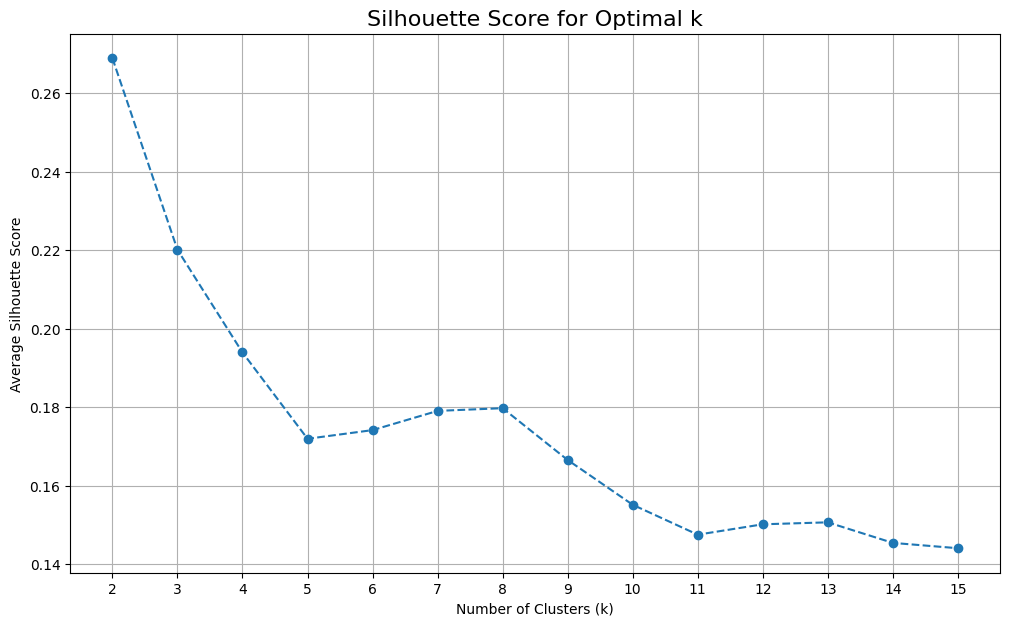

In [105]:
# 📏 silhouette_scores will store the average silhouette score for each k
silhouette_scores = []
# 🔢 Silhouette measures separation between clusters
k_range = range(2, 16)

# 🔄 Loop through each number of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Calculate the silhouette score and append it to our list
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 🎨 Plot the Silhouette Scores graph
plt.figure(figsize=(12, 7))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [106]:
# 🎯 7. Define our chosen number of clusters because the zoom of the analysis before
OPTIMAL_K = 8

# 🧠 8. Initialize and train the K-Means model
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_scaled)

KMeans(n_init=10, random_state=42)

In [107]:
# 🚀 9. Create our final analysis dataframe.
df_analysis = df_outfield_clean.copy()

# 🏷️ 10. Assign the new cluster labels to each player
df_analysis['cluster'] = kmeans.labels_

print("✅ Workflow Complete! Player archetypes have been assigned.")

✅ Workflow Complete! Player archetypes have been assigned.


In [108]:
# 📝 Display a sample of the final dataframe using the 'playerName' column that was already there to see all is right
print("\nSample of players with their assigned clusters:")
display(df_analysis[['playerName', 'minutesPlayed', 'cluster']].head())


Sample of players with their assigned clusters:


,playerName,minutesPlayed,cluster
0,Javier Güemez López,12245.0,1
4,Unai Bilbao Arteta,10515.0,7
5,Juan David Castro Ruiz,1863.0,4
6,Ricardo Chávez Soto,12372.0,5
8,Jair Alberto Díaz Vázquez,7573.0,6


In [109]:
# 👀 Display the number of players in each cluster
print("\nPlayer count per cluster:")
display(df_analysis['cluster'].value_counts().sort_index())


Player count per cluster:


,count
cluster,
0,86
1,83
2,84
3,31
4,47
5,56
6,61
7,111


In [110]:
# 📊 Group by cluster and calculate the mean for all metrics and see the arch.
cluster_profiles = df_analysis.groupby('cluster')[metrics_columns].mean()

# 🔄 Transposing the table (.T) makes it easier to read and compare.
print("Cluster Profiles (Average Metrics):")
display(cluster_profiles.T)

Cluster Profiles (Average Metrics):


cluster,0,1,2,3,4,5,6,7
def_OBV_p90,0.025483,0.051468,0.032911,0.031004,0.036445,0.048709,0.054146,0.073475
def_OppHalfRecoveries_p90,1.919427,2.451216,2.754907,2.775926,2.626547,1.699694,1.342271,0.721229
def_DuelWinRate,10.109010,30.111118,23.561351,25.986086,22.461633,25.946384,26.485675,24.917765
flow_WeightedDegree_p90,48.068980,84.102234,64.442072,79.068632,64.472554,68.164803,66.703120,65.073851
flow_Betweenness,0.134681,0.068195,0.091682,0.081485,0.098246,0.081393,0.084324,0.088707
flow_Eigenvector,0.191976,0.340151,0.273124,0.309298,0.265675,0.290801,0.291736,0.286282
off_xGChain_p90,0.937234,0.738710,0.846189,0.779088,1.379785,0.797946,0.760404,0.671936
off_FinishingDifferential,0.123639,-0.005770,-0.657468,5.651807,0.584138,-0.384712,0.067448,-0.299710
off_OpportunityCreation_p90,0.432682,0.143919,0.311890,0.370782,0.231232,0.111387,0.099082,0.064849
off_OBV_p90,-0.029993,0.112249,0.124162,0.191730,0.126308,0.159204,0.156819,0.069883


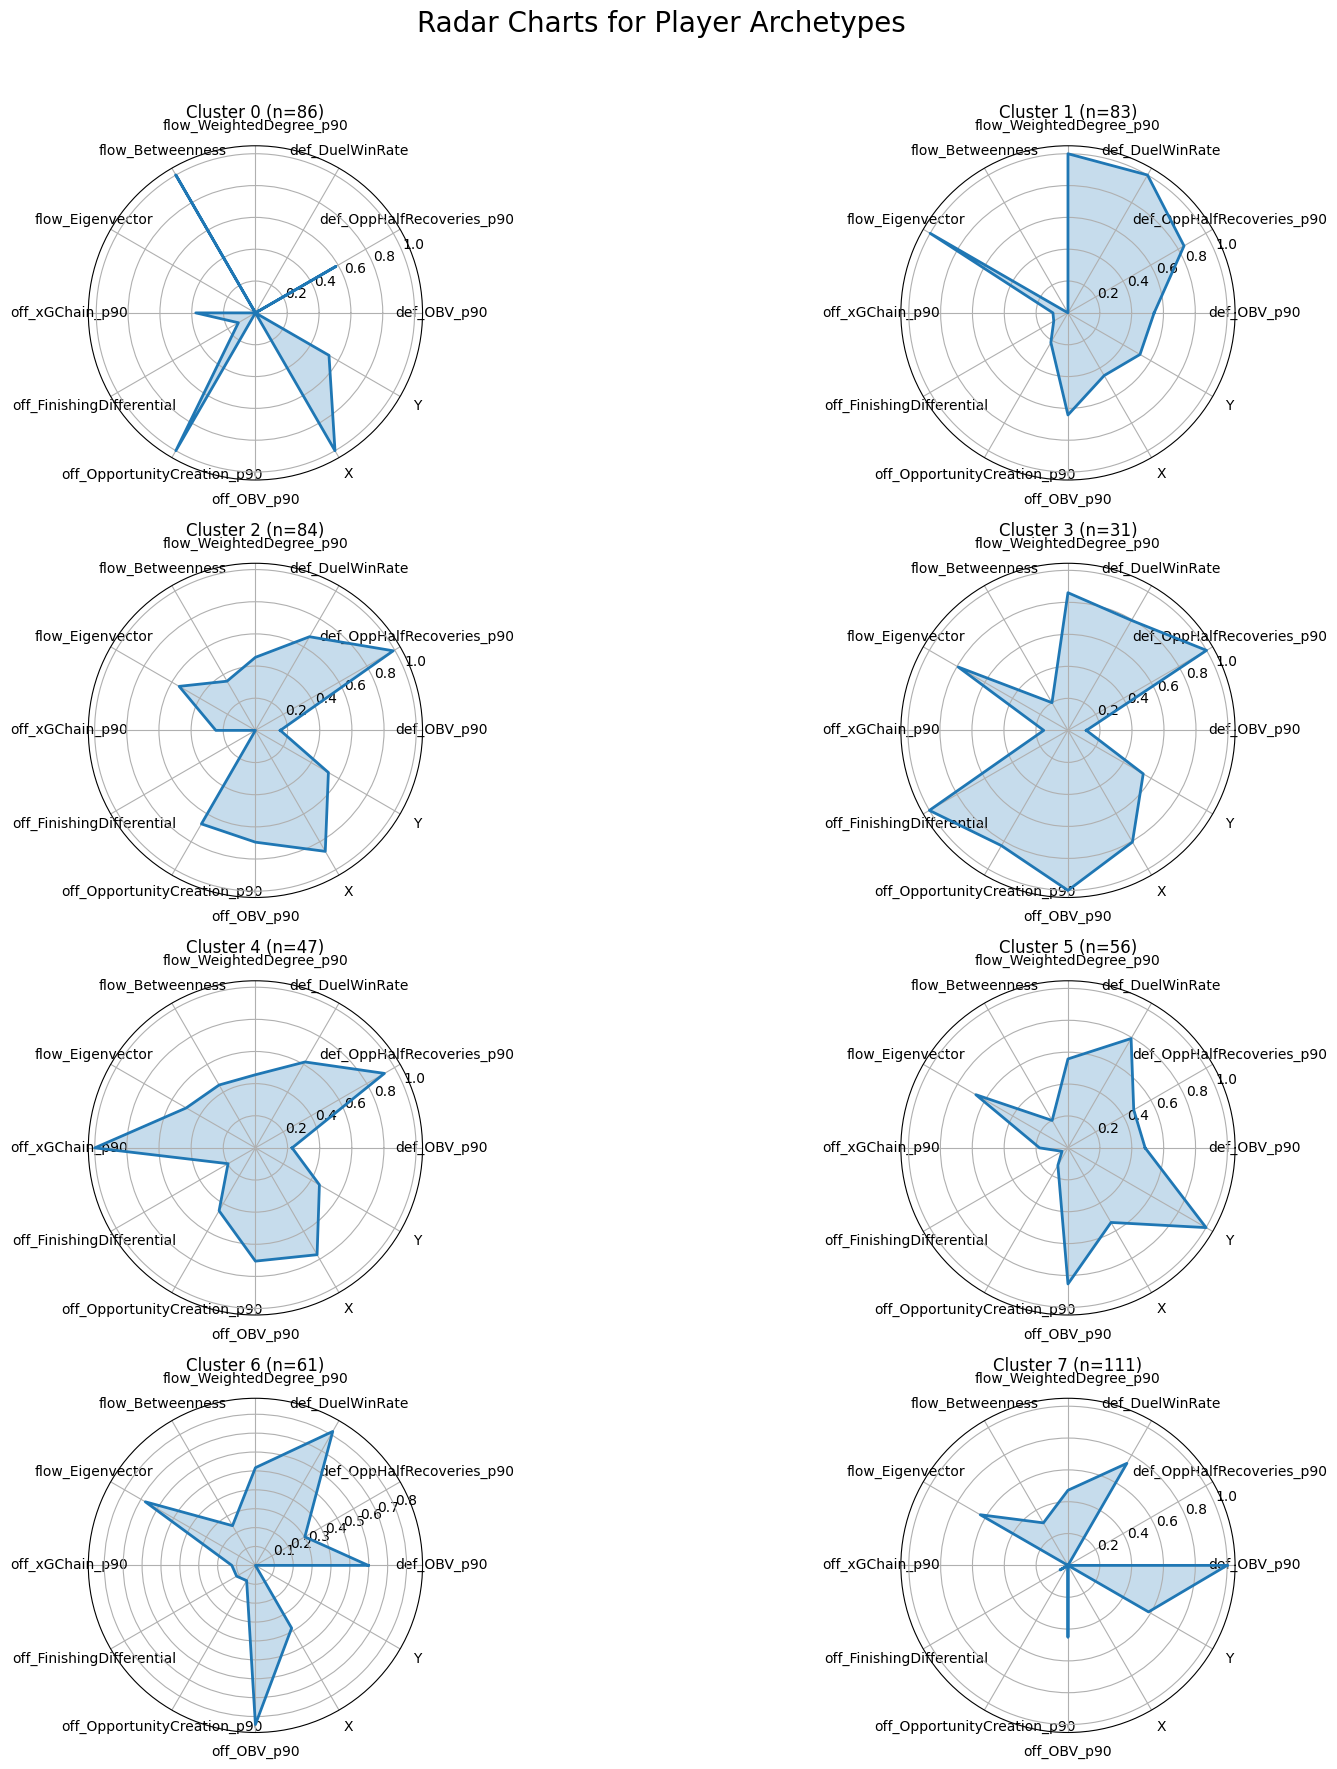

In [111]:
# ⚖️ Scale the profiles to a 0-1 range for a fair visual comparison.
scaler_viz = MinMaxScaler()
profiles_scaled = scaler_viz.fit_transform(cluster_profiles)
profiles_scaled = pd.DataFrame(profiles_scaled, columns=metrics_columns, index=cluster_profiles.index)

# Lets get the radar chart as well.
labels = np.array(metrics_columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(figsize=(18, 18), subplot_kw=dict(polar=True), nrows=4, ncols=2)
fig.suptitle('Radar Charts for Player Archetypes', fontsize=20)
axs = axs.flatten()

for i, (index, row) in enumerate(profiles_scaled.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]
    ax = axs[i]
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f'Cluster {index} (n={df_analysis["cluster"].value_counts()[index]})', pad=20)

for i in range(len(profiles_scaled), len(axs)):
    axs[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [112]:
# Now lets run the detecction of anomalies.

# 🧠 1. Initialize the Isolation Forest model.
# We'll set contamination to 0.05, meaning we're looking for the top 5% most unique players.
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# 🚀 2. Fit the model and predict the anomalies.
# The model is trained on the same scaled data used for clustering.
# .fit_predict() returns -1 for anomalies (outliers) and 1 for inliers (normal points).
anomaly_predictions = iso_forest.fit_predict(X_scaled)

# 🏷️ 3. Add the anomaly predictions to our main dataframe.
df_analysis['is_anomaly'] = anomaly_predictions

# 💎 4. Filter our dataframe to see only the hidden gems.
anomalous_players = df_analysis[df_analysis['is_anomaly'] == -1].copy()

In [117]:
# 📊 Define the key offensive metrics
offensive_metrics = ['minutesPlayed','off_xGChain_p90', 'off_FinishingDifferential', 'off_OpportunityCreation_p90', 'off_OBV_p90']

# 🚀 Display the anomalous players, sorted by the most impactful offensive metric
print("Top Anomalous Players by Offensive Metrics:")
display(anomalous_players[['playerName', 'cluster'] + offensive_metrics].sort_values(by='off_OpportunityCreation_p90', ascending=False).head(10))

Top Anomalous Players by Offensive Metrics:


,playerName,cluster,minutesPlayed,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90
1057,João Paulo Dias Fernandes,0,3351.0,0.595545,5.671953,0.722912,0.106060
86,Leonardo Cecilio Fernández López,3,4158.0,0.812342,5.380272,0.598708,0.313523
70,André-Pierre Gignac,0,10172.0,0.593873,5.269637,0.588900,-0.038099
875,Franck Boli,0,1588.0,0.784117,-1.088055,0.571935,-0.019886
970,Robert Osmar Morales Benítez,0,1944.0,1.208486,0.114947,0.525440,0.133522
958,Brandon Vázquez Toledo,0,1730.0,1.190929,2.445266,0.518304,0.192701
940,Sergio Canales Madrazo,3,5488.0,0.614020,10.364262,0.497211,0.178379
1147,Giorgos Giakoumakis,0,1688.0,1.048107,1.036240,0.496389,0.000743
228,Illian Gerardo Hernandez Vargas,0,1862.0,1.767721,-1.319042,0.479097,0.108147
1125,Oscar Eduardo Estupiñán Vallesilla,0,2111.0,0.603406,0.488724,0.424036,-0.092330


In [118]:
# 📊 Define the key flow/control metrics (Still working on it)
flow_metrics = ['minutesPlayed','flow_WeightedDegree_p90', 'flow_Betweenness', 'flow_Eigenvector']

# 🚀 Display the anomalous players, sorted by connectivity
print("\nTop Anomalous Players by Flow/Control Metrics:")
display(anomalous_players[['playerName', 'cluster'] + flow_metrics].sort_values(by='flow_Betweenness', ascending=False).head(10))


Top Anomalous Players by Flow/Control Metrics:


,playerName,cluster,minutesPlayed,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector
1147,Giorgos Giakoumakis,0,1688.0,40.787915,0.195847,0.118137
875,Franck Boli,0,1588.0,39.899244,0.186549,0.131554
904,Tahiel Adrián Jiménez Sánchez,0,1037.0,42.873674,0.177253,0.150625
881,Javier Hernández Balcázar,0,1374.0,35.436681,0.175996,0.113213
970,Robert Osmar Morales Benítez,0,1944.0,47.314815,0.172324,0.143103
1125,Oscar Eduardo Estupiñán Vallesilla,0,2111.0,38.498342,0.170608,0.161773
389,Jesús Alberto Ocejo Zazueta,0,1962.0,46.697248,0.163039,0.171261
571,Iván Andrés Morales Bravo,0,1000.0,39.510000,0.156115,0.143069
70,André-Pierre Gignac,0,10172.0,47.716280,0.148961,0.161180
228,Illian Gerardo Hernandez Vargas,0,1862.0,45.918367,0.148433,0.139771


In [115]:
# 📊 Define the key defensive metrics (Still working on it)
defensive_metrics = ['def_OBV_p90', 'def_OppHalfRecoveries_p90', 'def_DuelWinRate']

# 🚀 Display the anomalous players, sorted by high-pressing intensity
print("\nTop Anomalous Players by Defensive Metrics:")
display(anomalous_players[['playerName', 'cluster'] + defensive_metrics].sort_values(by='def_OppHalfRecoveries_p90', ascending=False).head(10))


Top Anomalous Players by Defensive Metrics:


,playerName,cluster,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate
167,Francisco Antonio Figueroa Díaz,4,0.041124,4.292643,24.074074
1075,Agustín Palavecino,1,0.074157,4.129164,27.040816
957,Marcelo Flores,4,0.030960,4.049347,23.636364
86,Leonardo Cecilio Fernández López,3,0.019391,3.203463,22.429907
427,Álvaro Fidalgo Fernández,1,0.030749,2.975919,26.095238
887,Oussama Idrissi,3,0.020965,2.721815,37.593985
940,Sergio Canales Madrazo,3,0.018238,2.623907,26.119403
142,Christopher Brayan Trejo Morantes,4,-0.006852,2.609383,13.000000
411,Jonathan dos Santos Ramírez,1,0.052806,2.468571,36.393443
970,Robert Osmar Morales Benítez,0,0.028031,2.407407,21.238938
